<a href="https://colab.research.google.com/github/Astra42/ImageComparison/blob/main/img_afine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

https://drive.google.com/file/d/11YT5cOpj8NkoJjWadLffypPR3rEedMVC/view?usp=share_link

In [ ]:
!gdown 11YT5cOpj8NkoJjWadLffypPR3rEedMVC

Downloading...
From: https://drive.google.com/uc?id=11YT5cOpj8NkoJjWadLffypPR3rEedMVC
To: /content/TemplatesJPG.zip
100% 9.99M/9.99M [00:00<00:00, 117MB/s]


In [ ]:
from zipfile import ZipFile

file_path ="/content/TemplatesJPG.zip"
with ZipFile(file_path, "r") as myzip:
    myzip.extractall(".")

Поворачиваем/сдвигем картинку

In [11]:
def rotate_and_moove(img, alpha, x, y, dop=0):
  alpha = alpha*np.pi/180
  h,w = img.shape
  w_padding = int(abs(h*np.sin(alpha)))
  h_padding = int(abs(w*np.sin(alpha)))
  x = w_padding if x<w_padding else x
  x = 0 if alpha>0 else x
  y = h_padding if y<h_padding else y
  y = 0 if alpha<0 else y
  afine_matrix = np.float32([[np.cos(alpha), np.sin(alpha), x], 
                             [-np.sin(alpha),  np.cos(alpha), y]])
  res = cv2.warpAffine(img, afine_matrix, (w+w_padding+dop*x,h+h_padding+dop*y),borderValue=255)
  return res


def preprocess(img_p, compr=1, pad = 0):
  img = cv2.imread(img_p)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  if compr!=1:
    h,w = img.shape
    img = cv2.resize(img,(int(compr*w), int(compr*h)))
  if pad>0:
    img = img[pad:-pad,pad:-pad]
  return img
  
img1 = preprocess("/content/big.png")
img2 = preprocess("/content/big with dif.png")
print(img1.shape, img2.shape)
i1 = rotate_and_moove(img1, 5, 0, 0)
i2 = rotate_and_moove(img2, 10, 0, 0)
#nh,nw = i1.shape
#i2 = cv2.resize(i2, (nw,nh))
print(i1.shape, i2.shape)
#cv2_imshow(i1)

(424, 600) (424, 600)
(476, 636) (528, 673)


Поиск ключевых точек

In [9]:
from scipy import stats


def find_angels(i, use_moda = True, hold=200):
  h,w = i.shape
  cord = np.array([[(j,i) for j in range(w)] for i in range(h)])

  white = stats.mode(i.reshape(-1))[0][0] if use_moda else hold
  black = cord[i<white-1]
  cv2_imshow(i)

  max_w = np.float32(max(black, key = lambda x: x[0]))
  min_w = np.float32(min(black, key = lambda x: x[0]))
  max_h = np.float32(max(black, key = lambda x: x[1]))
  min_h = np.float32(min(black, key = lambda x: x[1]))

  return np.float32([max_h,min_h,max_w])

<ipython-input-9-8b256332ba9a>:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  white = stats.mode(i.reshape(-1))[0][0] if use_moda else hold


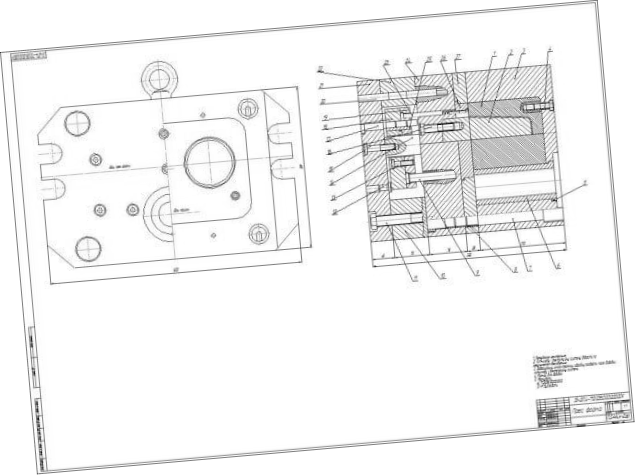

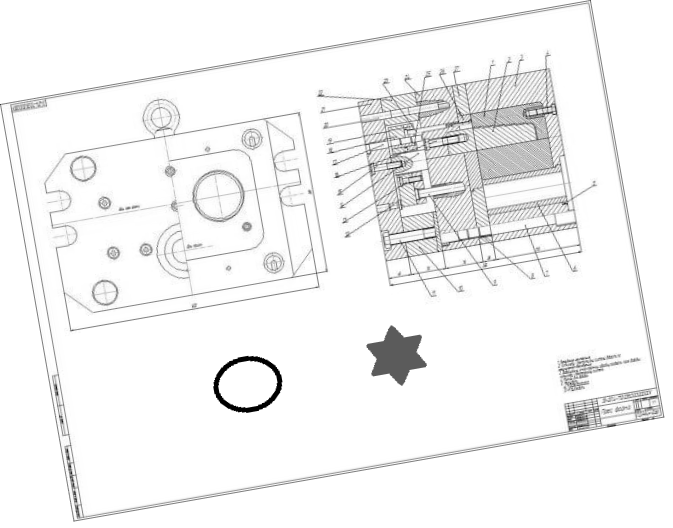

In [12]:
p1, p2 = find_angels(i1), find_angels(i2)

Рисуем найденные точки для однои из картинок

In [14]:
def draw_p(im, points):
  i = im.copy()
  for p in points:
    cv2.circle(i,(int(p[0]), int(p[1])), 10,(0,255,0), -1) 
  return i

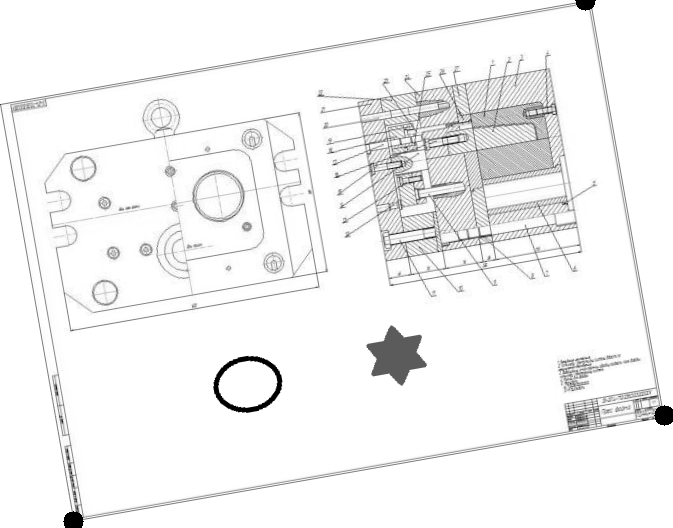

In [15]:
i = draw_p(i2, p2)
cv2_imshow(i)

Матрица афинного преобразования 2го изображения в 1ое

In [16]:
M= cv2.getAffineTransform(p2 , p1)
'''cos = (M[0,0] + M[1,1])/2
sin = (abs(M[0,1]) + abs(M[1,0]))/2

def sign(x):
  return 1 if x>0 else -1

M[0,0]=cos
M[1,1] = cos
M[0,1] = sign(M[0,1])*sin
M[1,0] = sign(M[1,0])*sin'''
M

array([[  0.9993337 ,  -0.06975268,  -0.61021373],
       [  0.07690063,   0.98536108, -44.9868711 ]])

In [17]:
M[0][0]**2 + M[1][0]**2

1.004581548887335

Преобразование 2го изображения

In [18]:
h,w = i1.shape
conv_i2 = cv2.warpAffine(i2, M, (w,h),borderValue=255)
#cv2_imshow(conv_i2)

Маска сходств 1го и преобразованного 2го

0.6509632154748691

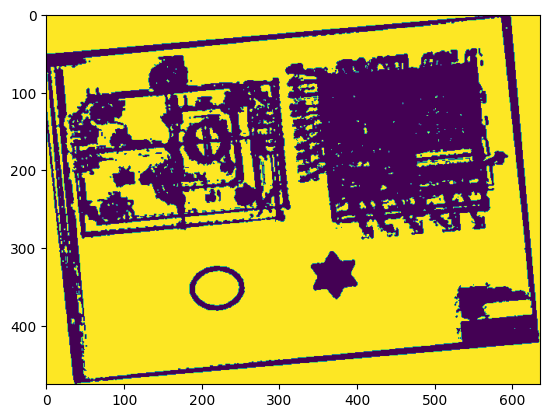

In [19]:
from PIL import Image, ImageChops

def binary_masks(i1, i2, use_m_filt=True, kernel_size=3, treshold=5):
    img = i1-i2
    if use_m_filt:
      #median_filter(img,kernel_size)
      img = cv2.medianBlur(img, kernel_size)
    similarity = np.vectorize(lambda x:True if x<=treshold else False)(img)
    difference = np.vectorize(lambda x:True if x> treshold else False)(img)
    return similarity, difference

s,d = binary_masks(i1, conv_i2)
h,w = s.shape

import matplotlib.pyplot as plt
plt.imshow(s)
s.sum().sum()/h/w

Маска сходств, основанная на более гибком способе сравнения изображений

0.8687899688177159

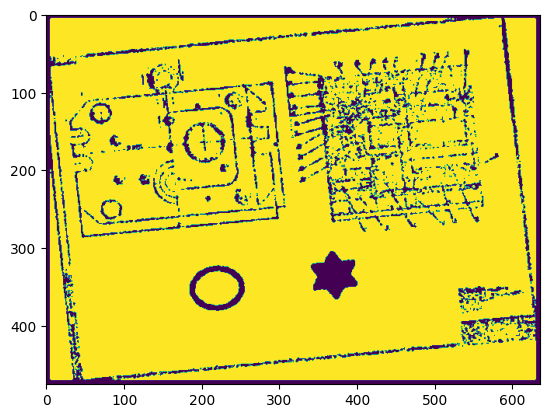

In [20]:
def binary_masks_with_kernel(i1,i2,k=3):
  h,w = i1.shape
  res = np.zeros((h,w))
  for i in range(k, h-k):
    for j in range(k, w-k):
      res[i,j] = i2[i,j] in i1[i-k:i+k+1,j-k:j+k+1]

  res = cv2.medianBlur(res.astype('uint8'), 3)
  return res

s = binary_masks_with_kernel(i1,conv_i2,k=5)
h,w = s.shape

import matplotlib.pyplot as plt
plt.imshow(s)
s.sum().sum()/h/w

Попытка реализовать собственный метод, создающий матрицу афинного преобразования 

In [ ]:
from decimal import Decimal
import math

def custom_afin_m(input_p , output_p):
  p11, p21 = map(lambda x: (int(x[0]), int(x[1])), input_p[0:2])
  p12, p22 = map(lambda x: (int(x[0]), int(x[1])), output_p[0:2])
  x1 = Decimal(p11[0])
  x2 = Decimal(p21[0])
  y1 = Decimal(p11[1])
  y2 = Decimal(p21[1])
  a1 = Decimal(p12[0])
  a2 = Decimal(p22[0])
  b1 = Decimal(p12[1])
  b2 = Decimal(p22[1])
  cos = Decimal((a1+a2-b1-b2)/2/(x1 - x2))
  sin = Decimal(math.sqrt((1-cos*cos)))
  #a = a1 - x1*cos + y1*sin
  #b = a2 - x1*cos - y1*sin
  #print(a,b)
  a = b1 - x2*cos + y2*sin
  b = b2 - x2*cos - y2*sin
  #print(a,b)
  return np.array([[float(cos), float(sin), float(a)],
          [float(-sin), float(cos), float(b)]])

custom_afin_m(p2,p1)

array([[-1.42578125e-01,  9.89783551e-01,  5.57408203e+02],
       [-9.89783551e-01, -1.42578125e-01,  8.34082031e+01]])

Метод, находящий маску сходств у двух изображений, подвергнутых только смещениям но не поворотам

In [2]:
def without_rot(img1, img2):
  h,w = img1.shape
  cord1 = np.array([[(j,i) for j in range(w)] for i in range(h)])
  h,w = img2.shape
  cord2 = np.array([[(j,i) for j in range(w)] for i in range(h)])

  black1 = cord1[img1<220]
  black2 = cord2[img2<220]

  max_w1 = np.float32(max(black1, key = lambda x: x[0]))[0]
  max_h1 = np.float32(max(black1, key = lambda x: x[1]))[1]
  max_w2 = np.float32(max(black2, key = lambda x: x[0]))[0]
  max_h2 = np.float32(max(black2, key = lambda x: x[1]))[1]

  return np.array([[1,0,-max_w2+max_w1],
                   [0,1,-max_h2+max_h1]])

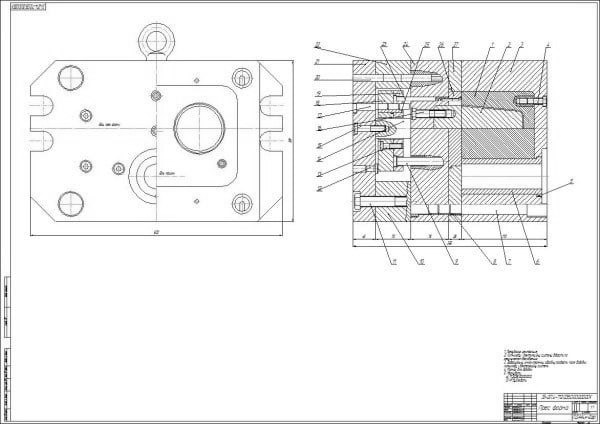

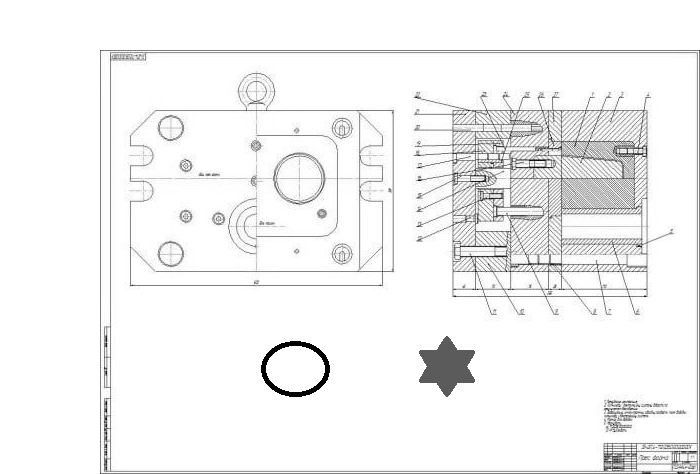

0.9887382075471698

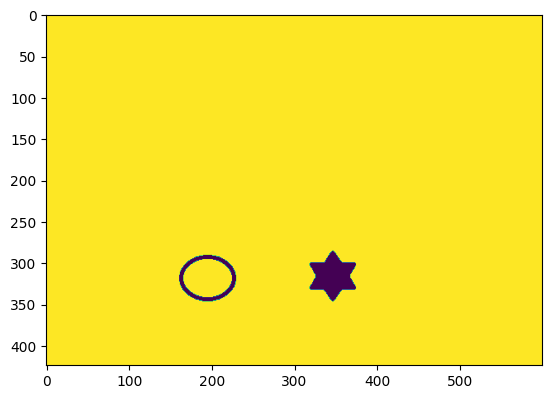

In [8]:
img1 = preprocess("/content/big.png")
img2 = preprocess("/content/big with dif.png")
i1 = rotate_and_moove(img1, 0, 0, 0)
cv2_imshow(i1)
i2 = rotate_and_moove(img2, 0, 100, 50, dop=1)
cv2_imshow(i2)
M = without_rot(i1,i2)
h,w = i1.shape
conv_i2 = cv2.warpAffine(i2, M, (w,h),borderValue=255)

s,d = binary_masks(i1, conv_i2)
h,w = s.shape

import matplotlib.pyplot as plt
plt.imshow(s)
s.sum().sum()/h/w

Далее ничего важного

In [ ]:
ret, thresh = cv2.threshold(i2, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

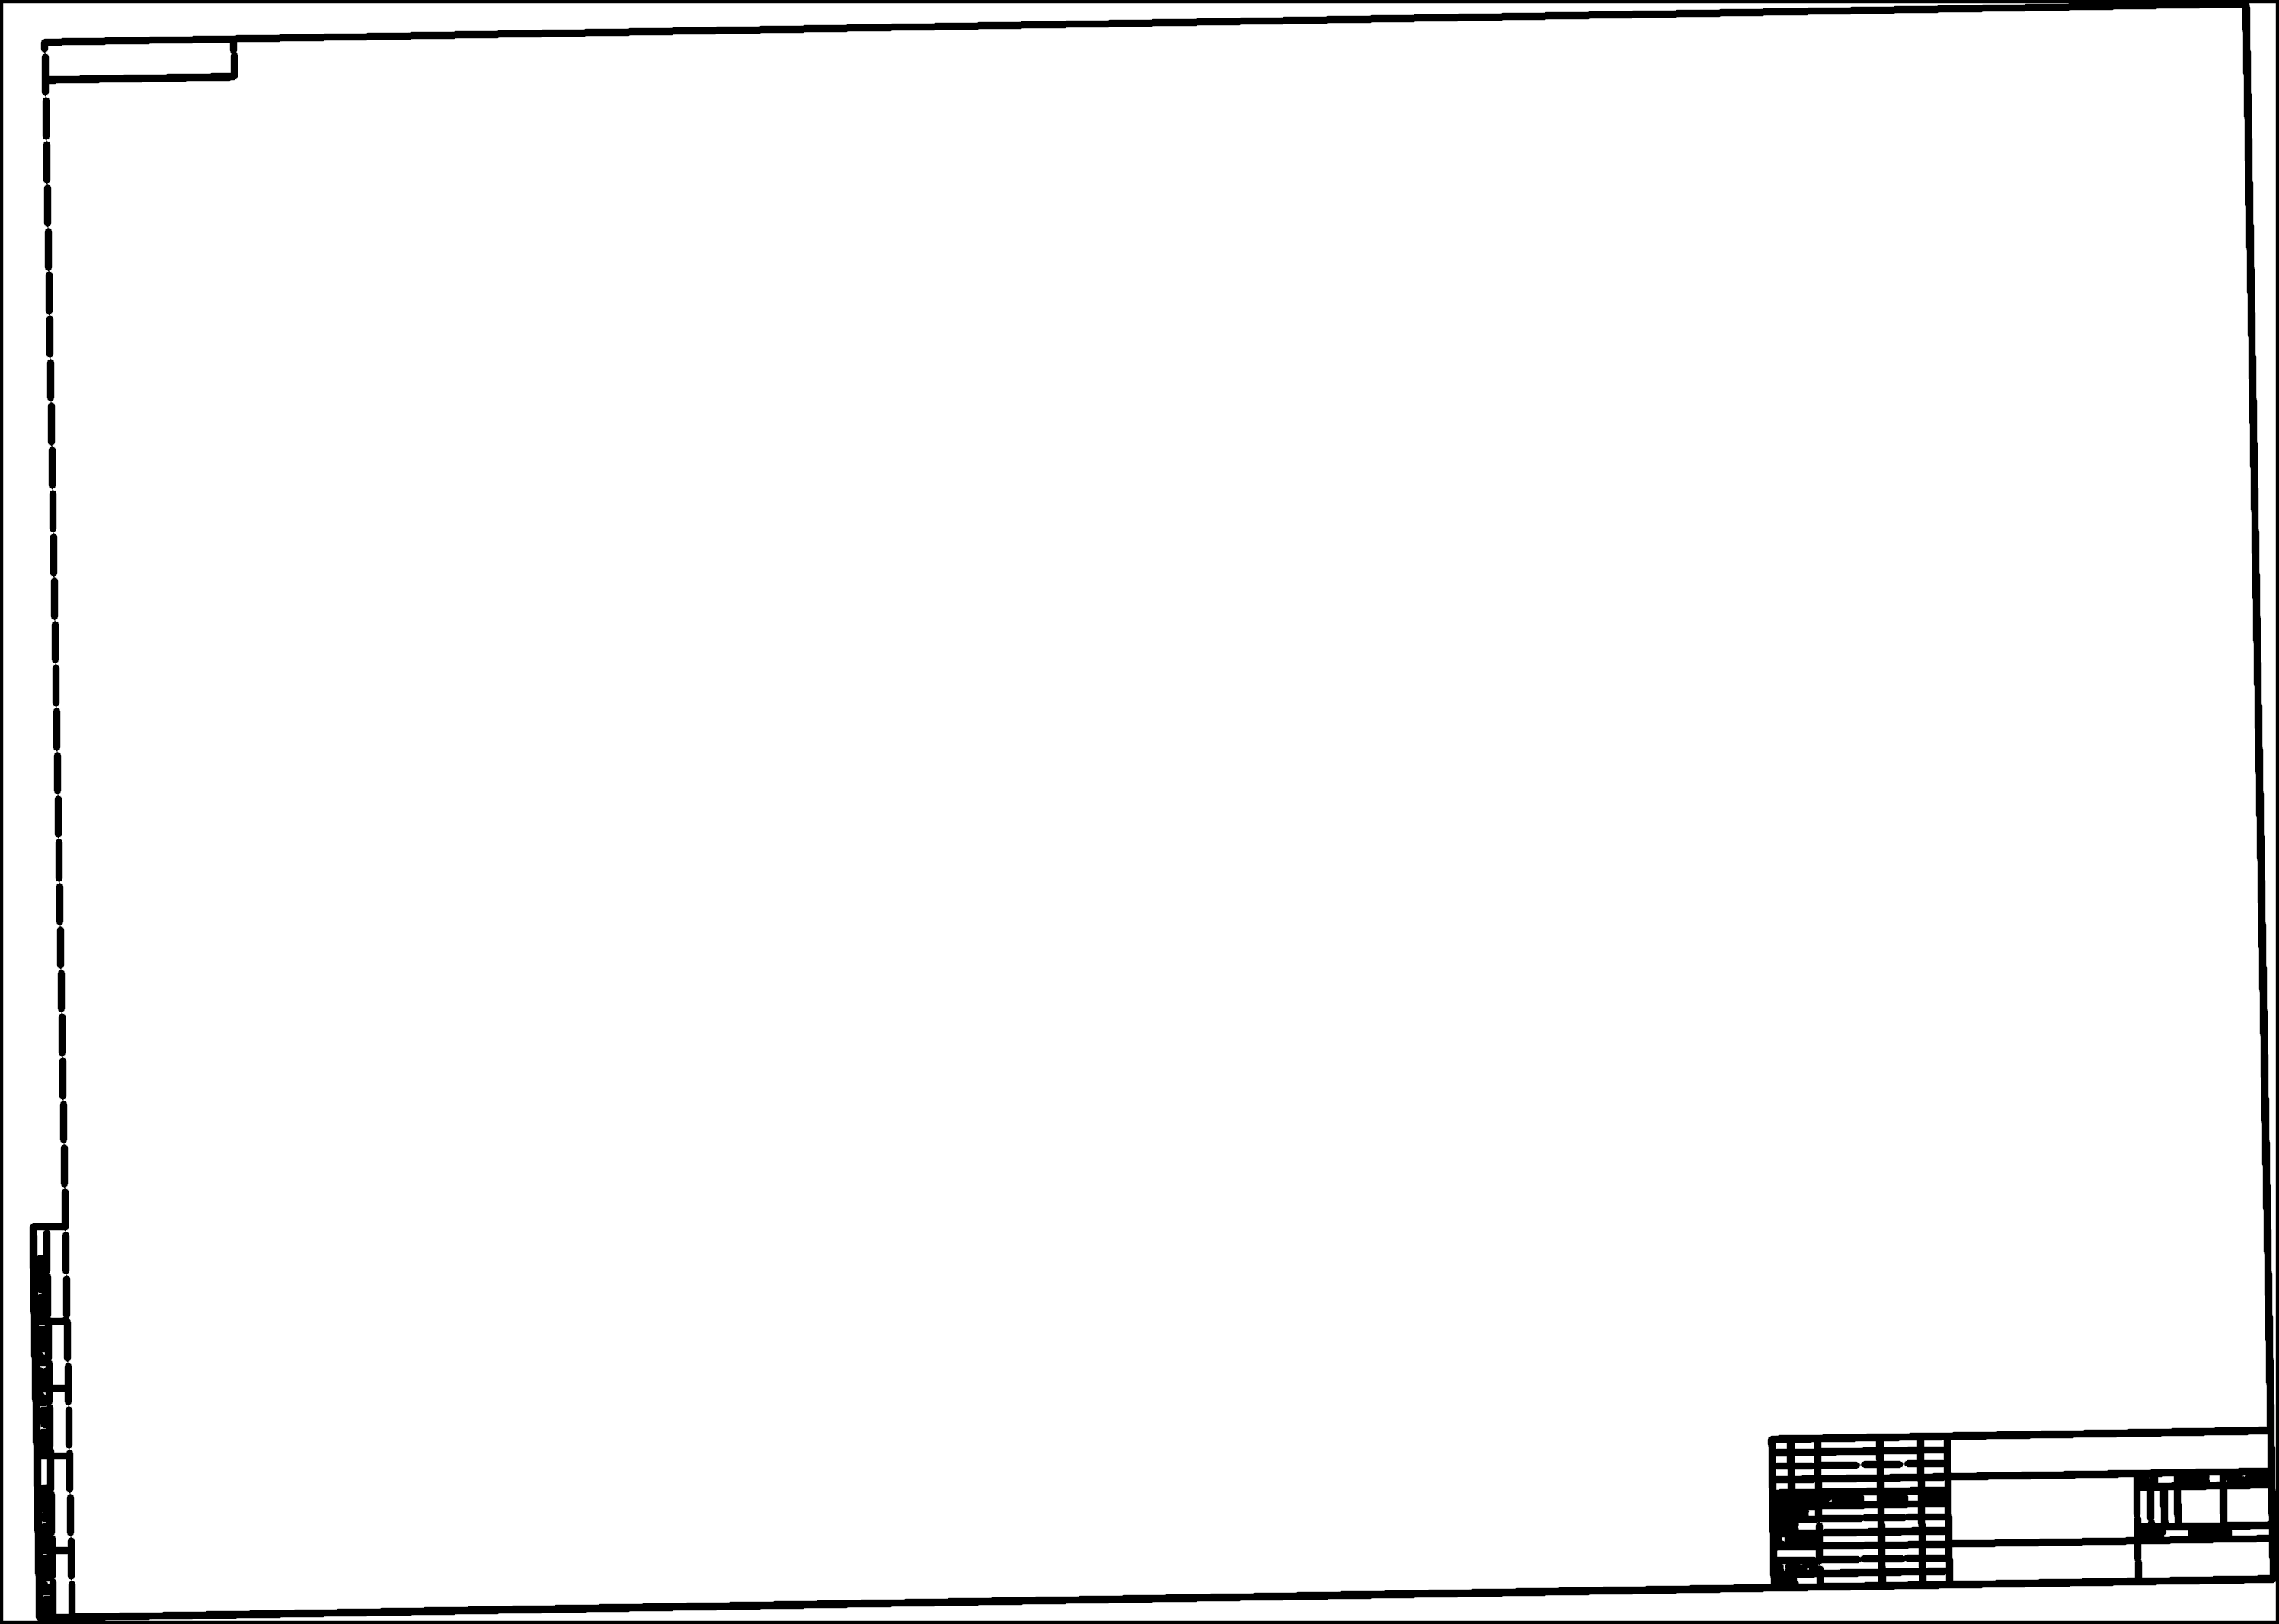

In [ ]:
image_copy = i2.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=5, lineType=cv2.LINE_AA)
cv2_imshow(image_copy)  

In [ ]:
def conturs_with_max_std(contours):
  max_y_std = 0
  max_x_std = 0
  contur_y = []
  contur_x = []

  for contur in contours:
    x = np.array([v[0][0] for v in contur])
    y = np.array([v[0][1] for v in contur])
    x_std = x.std()
    y_std = y.std()
    if x_std>max_x_std:
      max_x_std = x_std
      contur_x = contur
    if y_std>max_y_std:
      max_y_std = y_std
      contur_y = contur
  
  return contur_x, contur_y

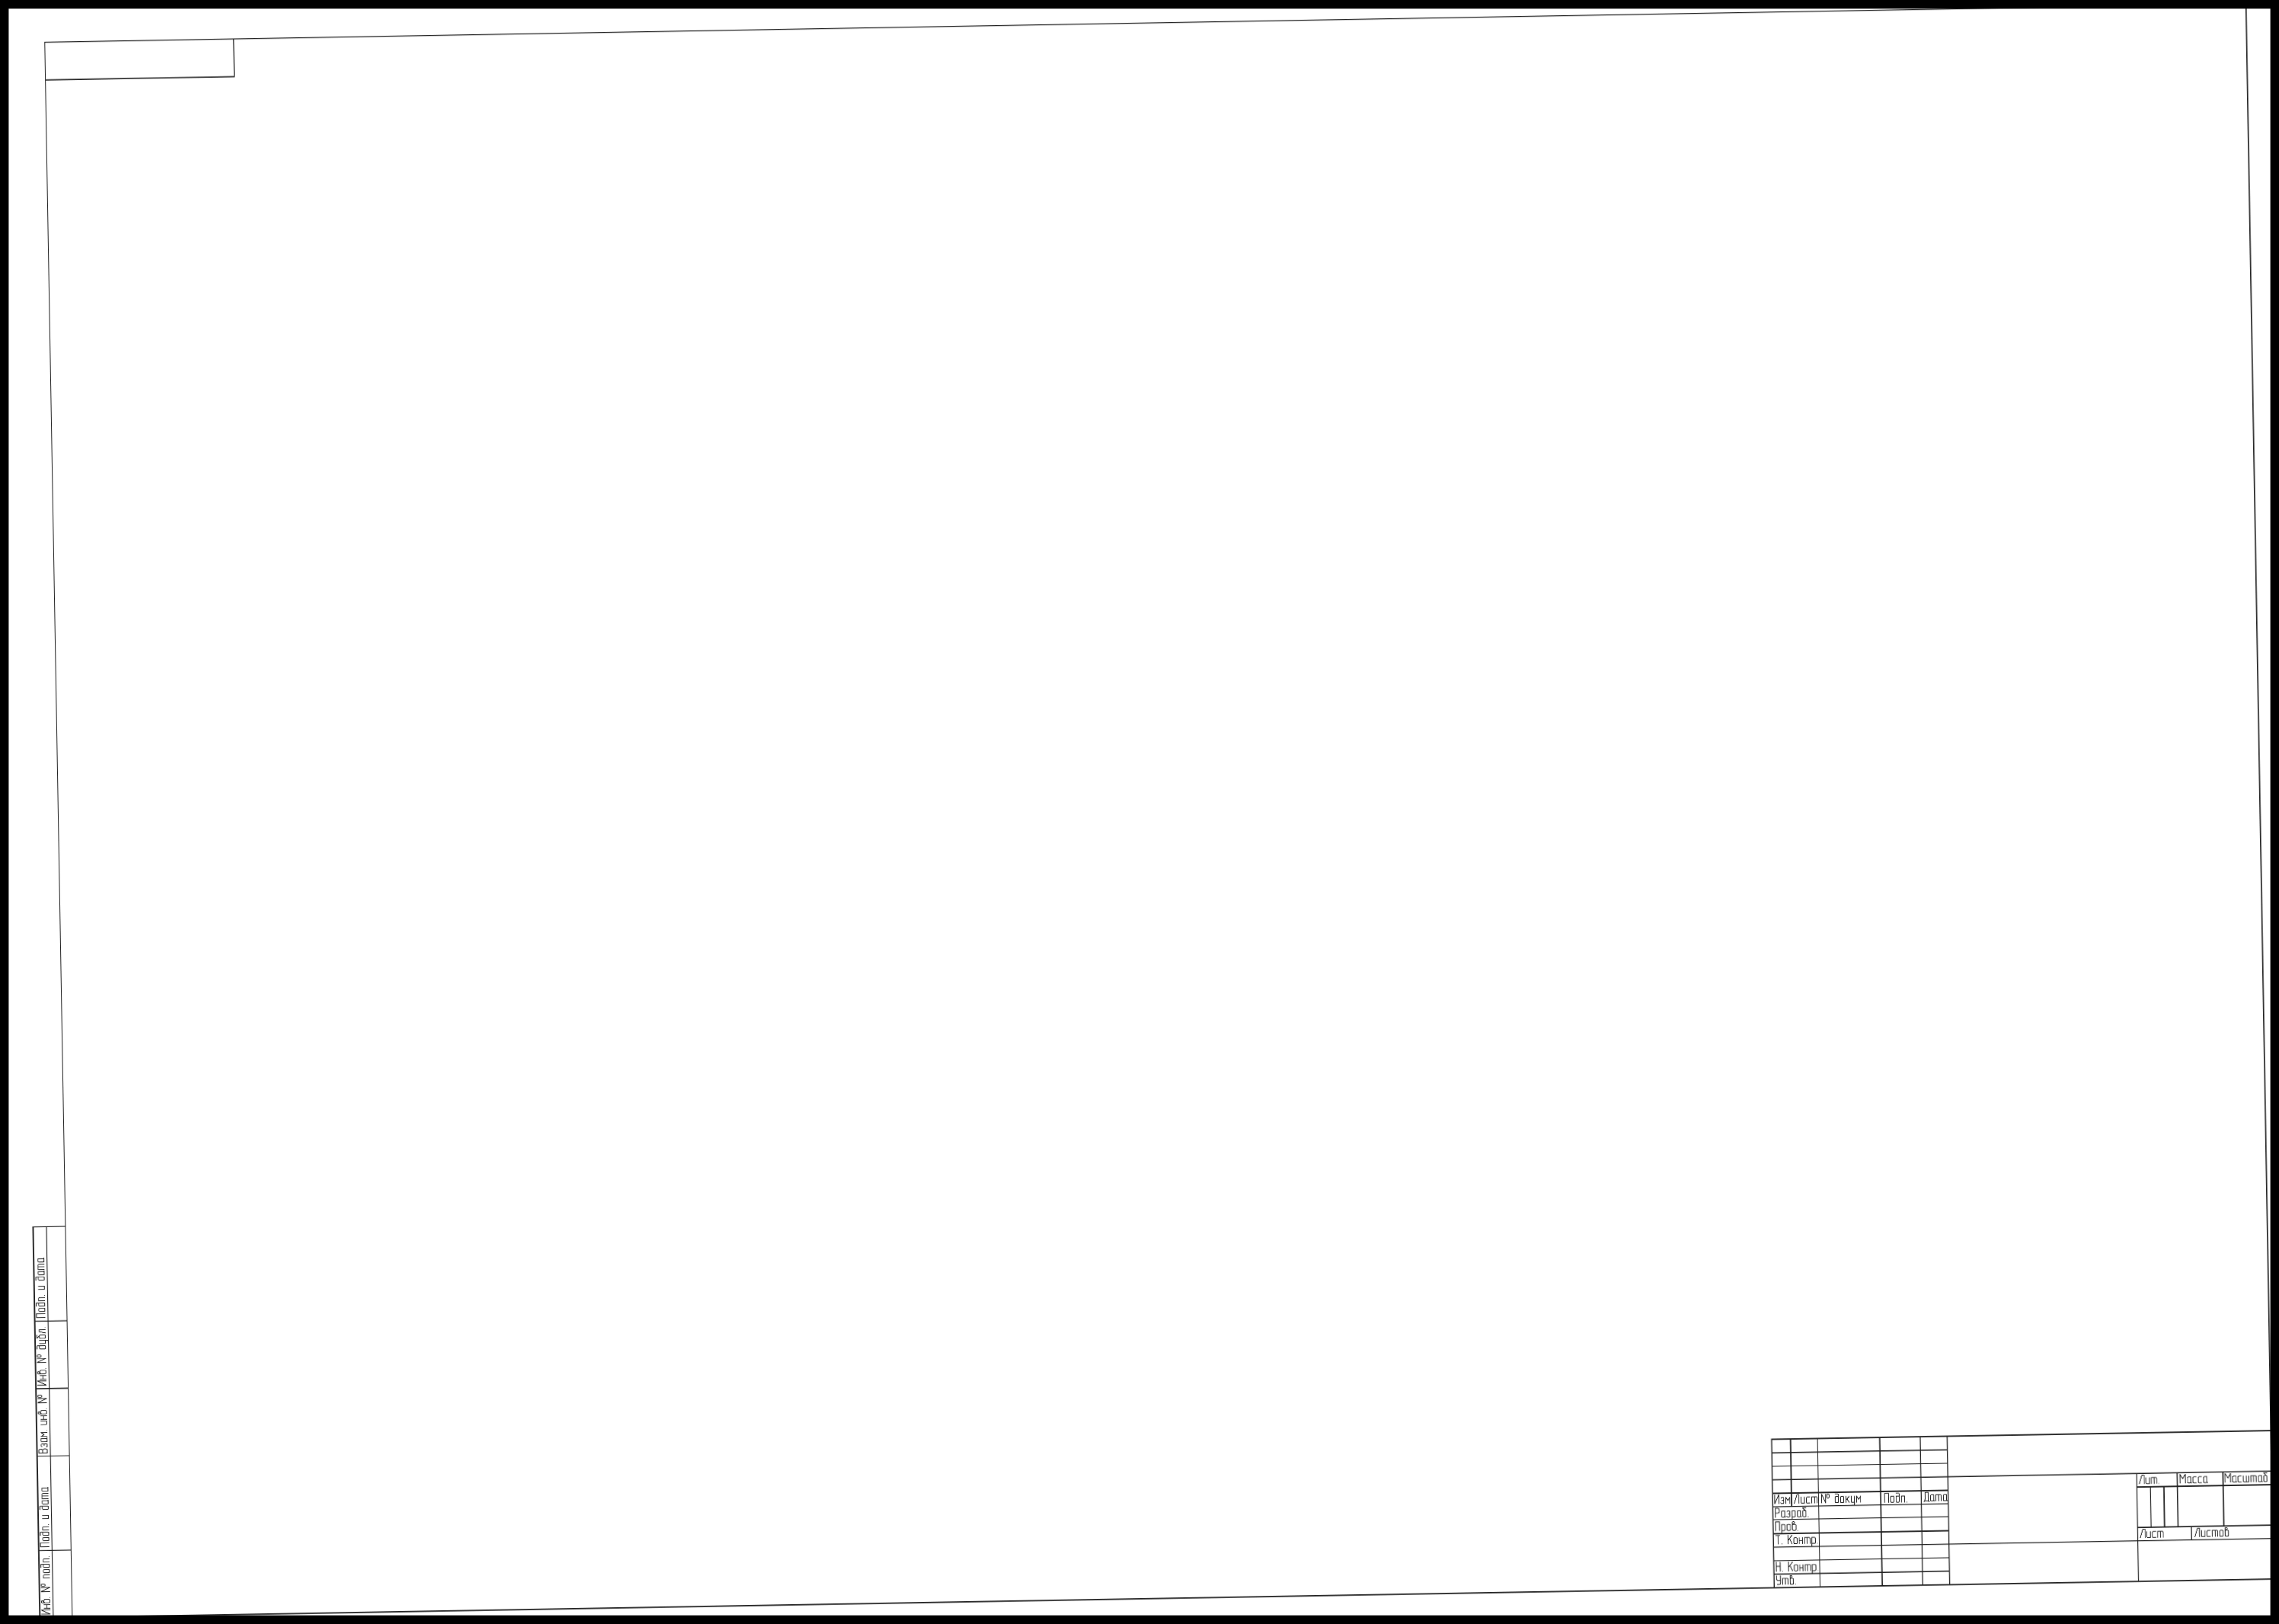

In [ ]:
c_x, c_y = conturs_with_max_std(contours)
image_copy = i2.copy()
cv2.drawContours(image=image_copy, contours=(c_y, c_x), contourIdx=-1, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
cv2_imshow(image_copy)  

In [ ]:
max(c_x, key = lambda x: x[0][1])[0][1], image_copy.shape[0]

(3480, 3508)

In [ ]:
h,w = img.shape
k=0.01
x,y = int(w*k), int(h*k)
obrez = img.copy()[x:-x, y:-y]
ret, thresh = cv2.threshold(obrez, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

c_x, c_y = conturs_with_max_std(contours)

In [ ]:
len(hierarchy)

1

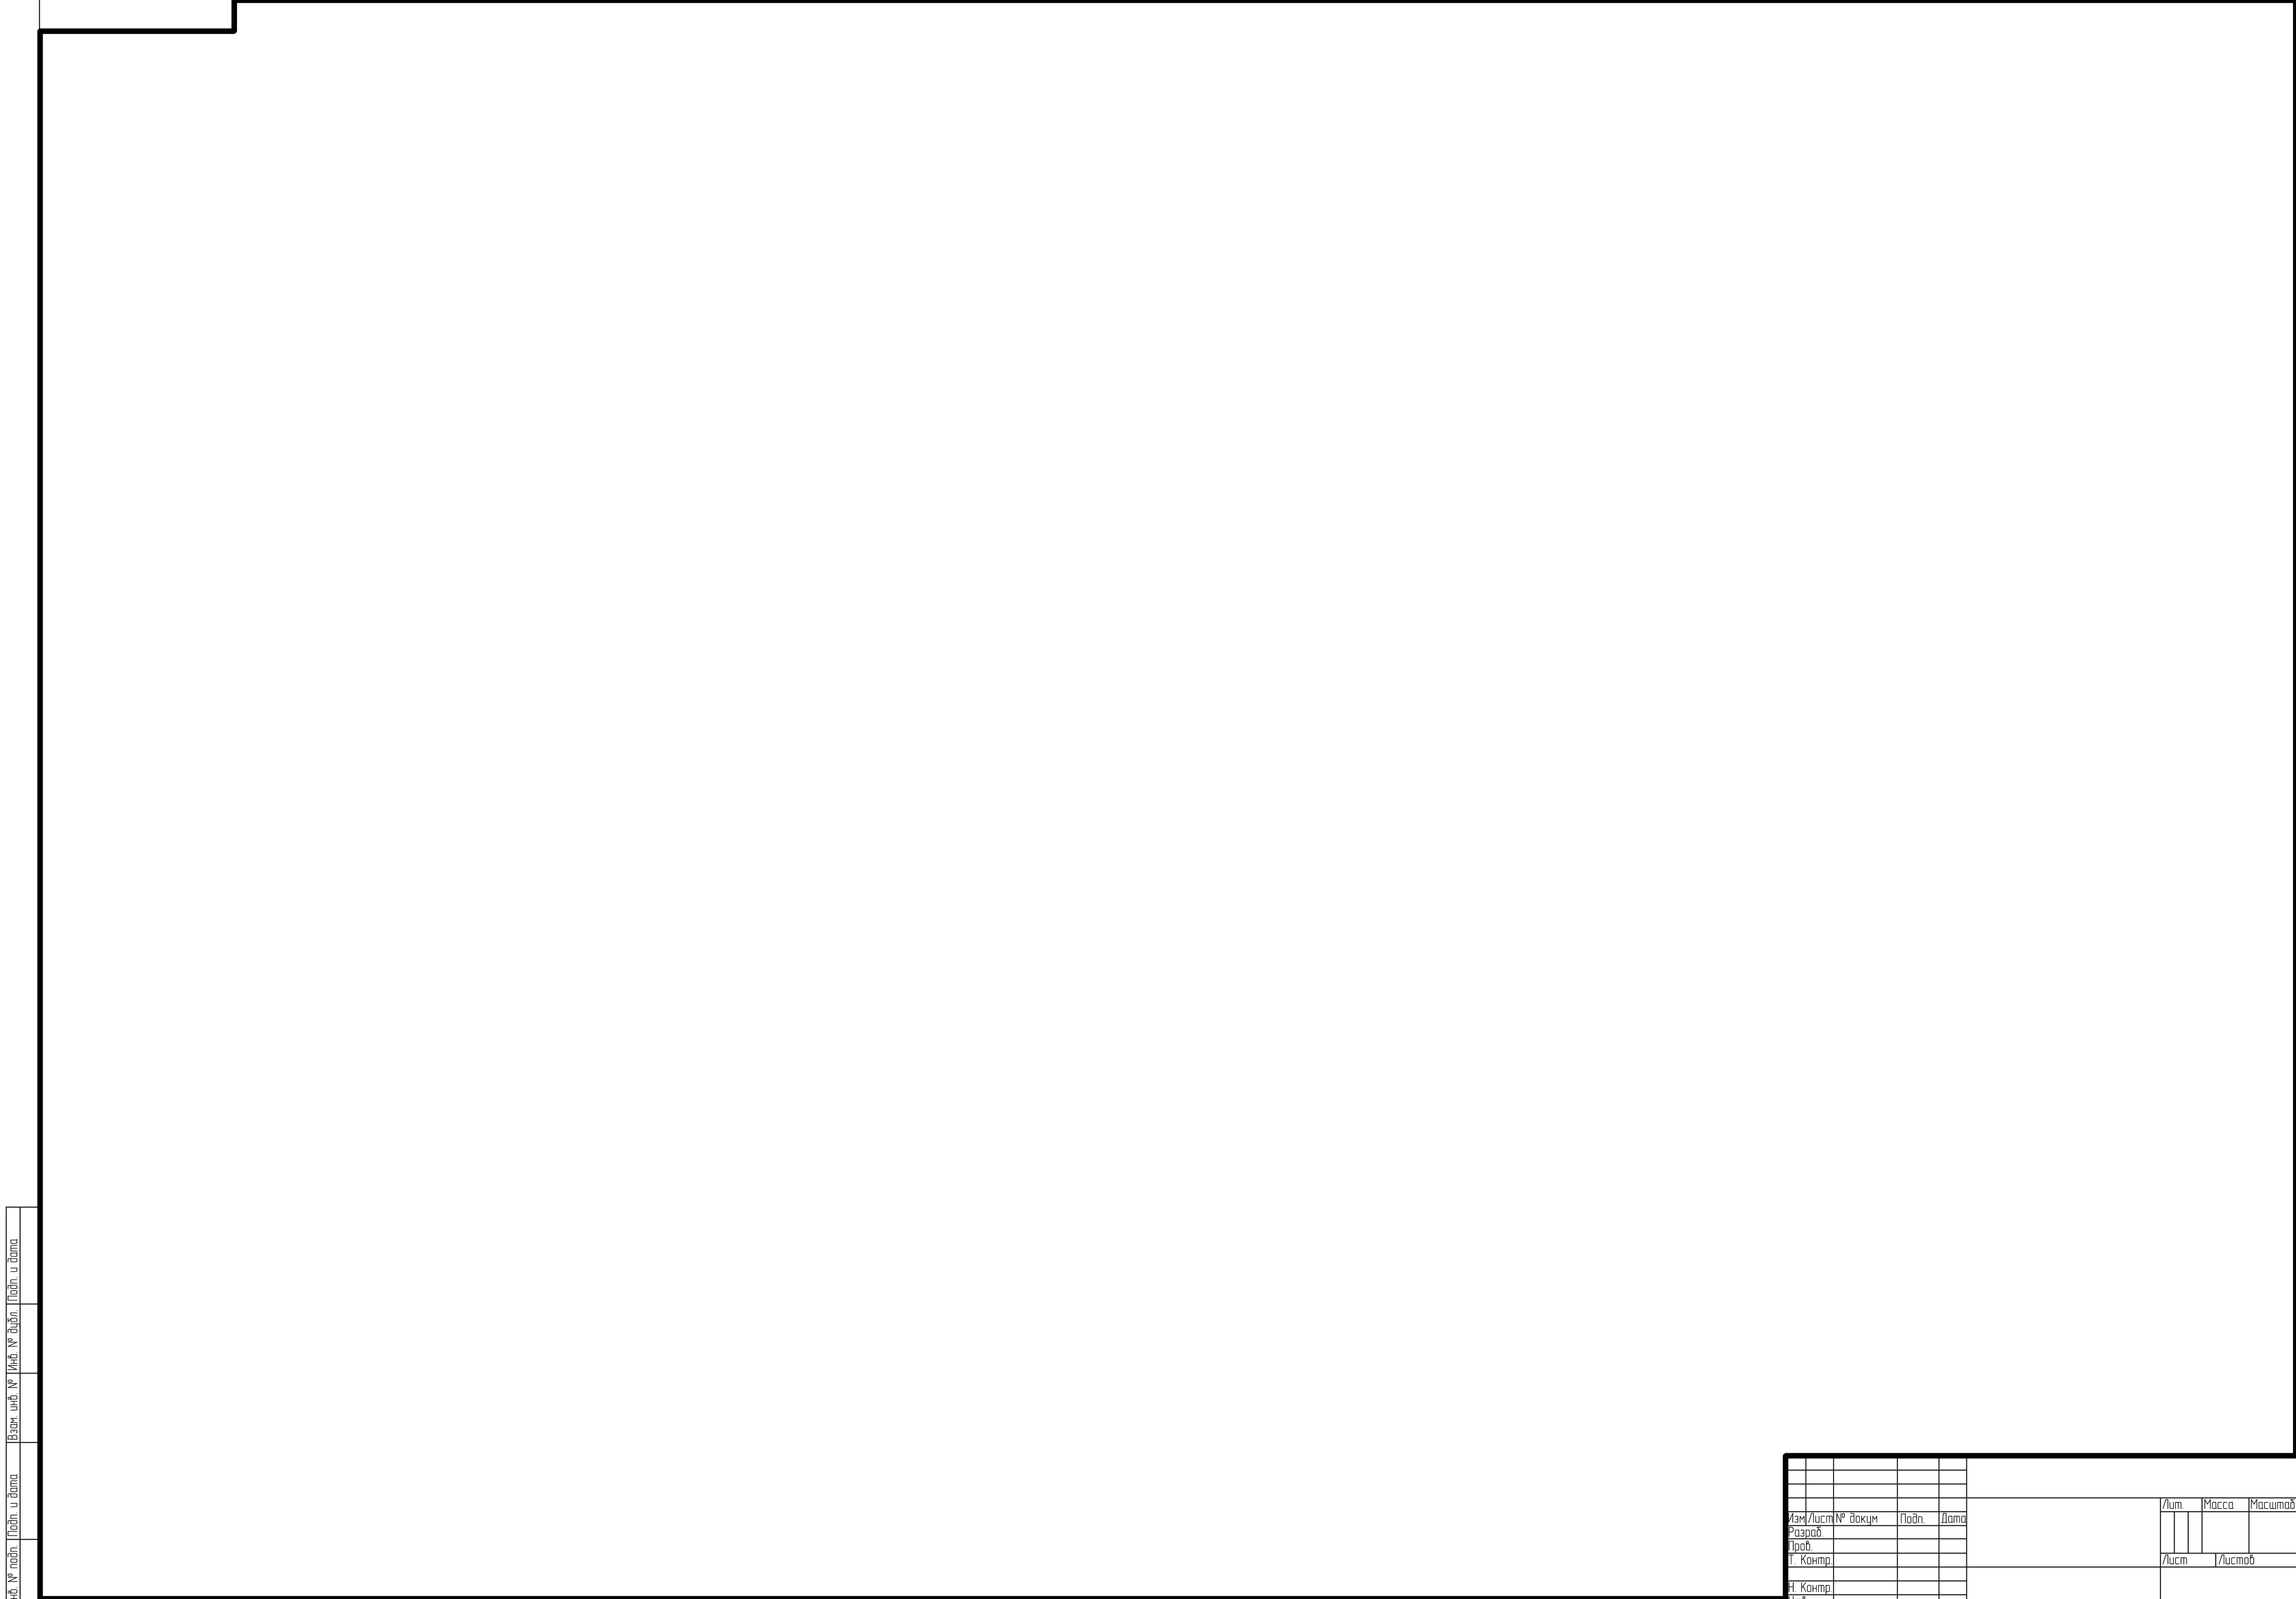

In [ ]:
image_copy = obrez.copy()
cv2.drawContours(image=image_copy, contours=(c_y, c_x), contourIdx=-1, color=(0, 255, 0), thickness=10, lineType=cv2.LINE_AA)
cv2_imshow(image_copy)